In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pandas as pd
import arviz as az
import os
from scipy.optimize import curve_fit

# Limits of MRT sump and pump infrastructure

Accumulated rainfall from 14th July to 7th October (when the pumps were inactive) would have accumulated up to 87% of the sump's capacity.

*Constants*
- Bishan stormwater sump pit's capacity, $C = 5044 m^3$
- 87% of sump's capacity, $0.87*5044 = 4388 m^3$
- Pump's flow rate to extract water to an external surface drainage system,$P = 85l/s = 0.085m^3/s$

*Estimations*
- Total daily rainfall from 14th July to 7th October, $R \approx 323.8 mm = 0.3238 m$
- Catchment area, $ A = 0.87C/R \approx 4388/0.3238 \approx 13551 m^2$ 
- Exposed train tracks around the station $~ 16800 m^2$

*Variables*
- Proportion of sump's capacity filled with water that would require shutting MRT, $\alpha$
- Number of pumps in operation, $n$ (between 0 to 3)
- Duration of rainfall, $t$

*Dependent variable*
- Rainfall rate, $R$ (m/s or mm/h)

Assuming rainfall rate is constant:

$$A \cdot R \cdot t - n \cdot P \cdot t = \alpha C$$
$$t(A R - n P) = \alpha C$$
$$R = \frac{1}{A}(\frac{\alpha C}{t} + n P)$$

Assuming rainfall rate is not constant:

$$A \cdot \int_0^t R(t)  dt - n \cdot P \cdot t = \alpha C$$

$$ \int_0^t R(t)  dt = \frac{\alpha C + n \cdot P \cdot t}{A} $$

The smallest rainfall intensity (long period rain) that is required to overwhelm the sump is if $t \rightarrow \inf$, then $R \approx \frac{nP}{A} $

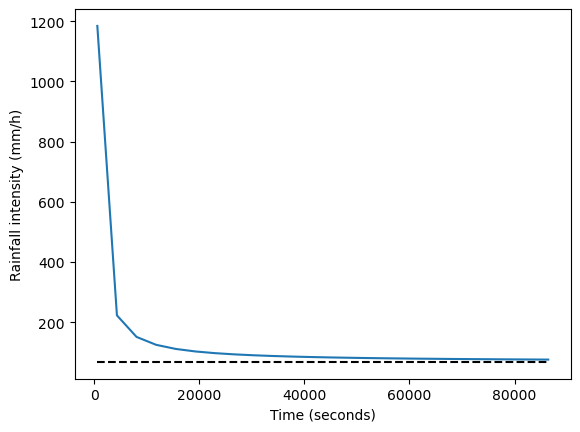

Maximum 60 mins Rainfall intensity to fill up half of sump's capacity: 253.86 mm/h
Long term Rainfall intensity to fill up half of sump's capacity: 67.74 mm/h


In [2]:
def rainfall_intensity_to_derail_MRT(alpha, n, t, A, C, P):
    """ 
    Estimate the rainfall intensity that would fill up the sump pit to overwhelm the anti-flooding system in MRT
    Args:
        alpha (float): Unitless. Proportion of sump's capacity that would initiate the shut down of MRT. 13% of the stormwater sump pit was filled with rainfall in the tunnels between Bishan and Braddel MRT stations
        n (float): Unitless. Number of high capacity pumps in operation
        t (float): Seconds. Duration of rainfall and pumps in operation
        A (float): m2. Catchment of area that would collect the rainwater which flows into the sump pit
        C (float): m3. Capacity of stormwater sump pit
        P (float): m3/s. Pump's flow rate
    """
    dR_dt = (1/A)*(alpha*C/t+n*P) # rate of rainfall over period t: m/s
    R = dR_dt*1000*3600 # to express rainfall in mm/h
    return R
rainfall_intensity_to_derail_MRT(alpha=0.5, n=3, t=3600, A=13551, C=5044, P=0.085)
min_rainfall_intensity = lambda n, P, A: n*P/A*3600000
rainfall_intensity_to_derail_MRT_lambda = lambda alpha, n, t, A, C, P: (3600000/A)*(alpha*C/t+n*P)
t = np.linspace(600, 86400, 24)
plt.figure()
plt.plot(t,[rainfall_intensity_to_derail_MRT_lambda(alpha=0.5, n=3, t=i, A=13551, C=5044, P=0.085) for i in t])
plt.hlines(min_rainfall_intensity(n=3,P=0.085,A=13551),xmin=t.min(),xmax=t.max(),linestyles="--",colors="k")
plt.xlabel("Time (seconds)")
plt.ylabel("Rainfall intensity (mm/h)")
plt.show()

rf_I = rainfall_intensity_to_derail_MRT_lambda(alpha=0.5, n=3, t=3600, A=13551, C=5044, P=0.085)
rf_min = min_rainfall_intensity(n=3,P=0.085,A=13551)
print(f"Maximum 60 mins Rainfall intensity to fill up half of sump's capacity: {rf_I:.2f} mm/h")
print(f"Long term Rainfall intensity to fill up half of sump's capacity: {rf_min:.2f} mm/h")

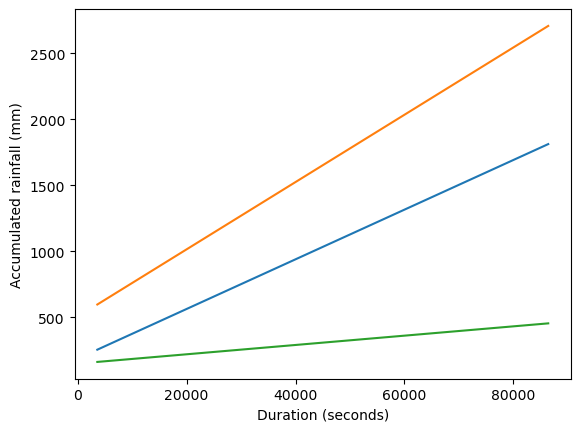

In [97]:
def rainfall_to_derail_MRT(alpha, n, t, A, C, P):
    """ 
    Estimate the rainfall intensity that would fill up the sump pit to overwhelm the anti-flooding system in MRT
    Args:
        alpha (float): Unitless. Proportion of sump's capacity that would initiate the shut down of MRT. 13% of the stormwater sump pit was filled with rainfall in the tunnels between Bishan and Braddel MRT stations
        n (float): Unitless. Number of high capacity pumps in operation
        t (float): Seconds. Duration of rainfall and pumps in operation
        A (float): m2. Catchment of area that would collect the rainwater which flows into the sump pit
        C (float): m3. Capacity of stormwater sump pit
        P (float): m3/s. Pump's flow rate
    """
    R = (alpha*C+n*P*t)/A # rate of rainfall over period t: m/s
    # multiply by 1000 to convert m to mm
    return R*1000

plt.figure()
t = np.arange(1,25)*3600 # to convert to seconds
plt.plot(t,[rainfall_to_derail_MRT(alpha=0.5, n=3, t=i, A=13551, C=5044, P=0.085) for i in t])
plt.plot(t,[rainfall_to_derail_MRT(alpha=1, n=3, t=i, A=10000, C=5044, P=0.085) for i in t])
plt.plot(t,[rainfall_to_derail_MRT(alpha=0.5, n=1, t=i, A=17000, C=5044, P=0.060) for i in t])
plt.ylabel("Accumulated rainfall (mm)")
plt.xlabel("Duration (seconds)")
plt.show()

# The probabilistic way, assuming uncertainties in parameters

### Model distribution of required rainfall intensity (mm/hr) to fill up more than half of stormwater sump's capacity

(Not recommended): because this assumes rainfall is constant with time, when in reality, it follows a Gumbel distribution

In [ ]:
# --- Known constants ---
C = 5044.0                      # sump capacity (m³)
A_low, A_high = 10000.0, 17000.0  # catchment area range (m²)
alpha_low, alpha_high = 0.5, 1.0  # fill proportion range
P_mu, P_sigma = 0.085, 0.085 * 0.15  # pump rate mean ±15%
n_values = [0, 1, 2, 3]          # number of pumps in operation

# Durations (10 min to 24 hr)
durations_hr = np.array([1/6, 0.5, 1, 3, 6, 12, 24])
durations_s = durations_hr * 3600

# -------------------------
# Model + sampling (joint, hierarchical per n)
# -------------------------
# We will fit one hierarchical model per fixed n (shared A, alpha, P across durations),
# because R depends on t and n deterministically given A,alpha,P.
all_results = {}  # store posterior samples of R for each (n, duration index)

# --- Joint hierarchical model ---
for n in n_values:
    print(f"Sampling for n = {n} pumps ...")
    with pm.Model() as model:
        # Shared uncertain parameters
        A = pm.Uniform("A", lower=A_low, upper=A_high)
        alpha = pm.Uniform("alpha", lower=alpha_low, upper=alpha_high)
        P = pm.TruncatedNormal("P", mu=P_mu, sigma=P_sigma, lower=0)

        # Deterministic rainfall rate per duration
        R_list = []
        for i, t in enumerate(durations_s):
            R_m_per_s = (alpha * C / t + n * P) / A
            R_mm_per_hr = pm.Deterministic(f"R_mm_per_hr_{i}", R_m_per_s * 1000 * 3600)
            R_list.append(R_mm_per_hr)

        # Sample posterior
        trace = pm.sample(
            draws=4000, tune=1000, chains=4,
            target_accept=0.9, progressbar=True, random_seed=42
        )

    # Summarize rainfall intensities
    # Extract posterior samples for R for each duration
    posterior = az.extract(trace)  # dictionary-like; keys are variable names
    # `posterior` returns arrays shaped (draws*chains, ) for deterministic vars
    n_results = {}
    for i, t in enumerate(durations_s):
        key = f"R_mm_per_hr_{i}"
        samples = np.asarray(posterior[key])  # 1D array of posterior samples for R at duration i
        n_results[int(t)] = samples
    all_results[int(n)] = n_results
        

Sampling for n = 0 pumps ...


c:\Users\hypak\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, alpha, P]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 42 seconds.


Sampling for n = 1 pumps ...


c:\Users\hypak\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, alpha, P]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 41 seconds.


Sampling for n = 2 pumps ...


c:\Users\hypak\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, alpha, P]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 40 seconds.
c:\Users\hypak\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...


Sampling for n = 3 pumps ...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, alpha, P]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 41 seconds.


### Model distribution of required accumulated rainfall (mm) to fill up more than half of stormwater sump's capacity

In [103]:
# --- Known constants ---
C = 5044.0                      # sump capacity (m³)
A_low, A_high = 10000.0, 17000.0  # catchment area range (m²)
alpha_low, alpha_high = 0.5, 1.0  # fill proportion range
P_mu, P_sigma = 0.085, 0.085 * 0.15  # pump rate mean ±15%
n_values = [0, 1, 2, 3]          # number of pumps in operation

# Durations (10 min to 24 hr)
durations_hr = np.arange(1,25)
durations_s = durations_hr * 3600 # change to seconds

# -------------------------
# Model + sampling (joint, hierarchical per n)
# -------------------------
# We will fit one hierarchical model per fixed n (shared A, alpha, P across durations),
# because R depends on t and n deterministically given A,alpha,P.
R_mm_results = {}  # store posterior samples of R for each (n, duration index)

# --- Joint hierarchical model ---
for n in n_values:
    print(f"Sampling for n = {n} pumps ...")
    with pm.Model() as model:
        # Shared uncertain parameters
        A = pm.Uniform("A", lower=A_low, upper=A_high)
        alpha = pm.Uniform("alpha", lower=alpha_low, upper=alpha_high)
        P = pm.TruncatedNormal("P", mu=P_mu, sigma=P_sigma, lower=0)

        # Deterministic rainfall rate per duration
        R_list = []
        for i, t in enumerate(durations_s):
            R_m = (alpha * C + n * P * t) / A
            R_mm = pm.Deterministic(f"R_mm_{i}", R_m * 1000)
            R_list.append(R_mm)

        # Sample posterior
        trace = pm.sample(
            draws=4000, tune=1000, chains=4,
            target_accept=0.9, progressbar=True, random_seed=42
        )

    # Summarize rainfall intensities
    # Extract posterior samples for R for each duration
    posterior = az.extract(trace)  # dictionary-like; keys are variable names
    # `posterior` returns arrays shaped (draws*chains, ) for deterministic vars
    n_results = {}
    for i, t in enumerate(durations_s):
        key = f"R_mm_{i}"
        samples = np.asarray(posterior[key])  # 1D array of posterior samples for R at duration i
        n_results[int(t)] = samples
    R_mm_results[int(n)] = n_results
        

Sampling for n = 0 pumps ...


c:\Users\hypak\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, alpha, P]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 46 seconds.


Sampling for n = 1 pumps ...


c:\Users\hypak\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, alpha, P]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 35 seconds.


Sampling for n = 2 pumps ...


c:\Users\hypak\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, alpha, P]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 34 seconds.


Sampling for n = 3 pumps ...


c:\Users\hypak\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, alpha, P]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 35 seconds.


### Import IDF 100 RP

In [78]:
PUB_100RP_df = pd.read_csv(r"PUB IDF\PUB_IDF_1in100yr_RP.csv")
PUB_100RP_df = PUB_100RP_df[PUB_100RP_df["Time (mins)"]>30]
PUB_100RP_df

future_100RP_df = pd.read_csv(r"PUB IDF\ssp585_pr_1hr_EC-Earth3_2080-2099_IDF_1in100yr_RP.csv")
future_100RP_df

,Time (mins),Rainfall Intensity (mm/hr)
0,60,261.631293
1,120,208.122670
2,180,183.379800
3,240,170.462159
4,300,160.184146
5,360,156.125067
6,420,146.406444
7,480,132.881965
8,540,123.366710
9,600,115.455400


### Curve fitting for IDF

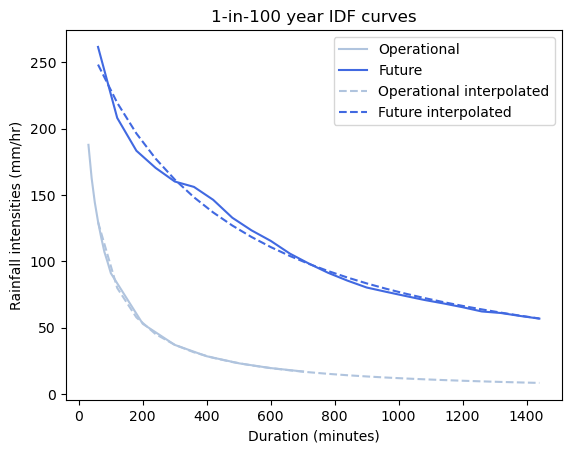

In [93]:
def curve_fit_IDF(func, x,y, xdata):
    """ 
    Args:
        x (np.ndarray): time in seconds
        y (np.ndarray): rainfall intensities (mm/hr)
        xdata (np.ndarray): new x data
    Returns:
        nd.array: interpolated y data
    """
    popt, pcov = curve_fit(func, x, y)
    y_hat = func(xdata, *popt)
    return y_hat

def log_func(x, a, b, c):
    return a * np.log(b * x) + c

def parametric_func(x, a, b, c):
    return a/((x+b)**c)

fig, ax = plt.subplots(1,1)
ax.plot(PUB_100RP_df["Time (mins)"].values[:-1] ,PUB_100RP_df["Rainfall Intensity (mm/hr)"].values[:-1],c="lightsteelblue",label="Operational")
ax.plot(future_100RP_df["Time (mins)"],future_100RP_df["Rainfall Intensity (mm/hr)"],c="royalblue",label="Future")
xdata = np.arange(1,25)*60 # to convert into minutes
interpolated_PUB = curve_fit_IDF(parametric_func,PUB_100RP_df["Time (mins)"],PUB_100RP_df["Rainfall Intensity (mm/hr)"], xdata)
interpolated_future = curve_fit_IDF(parametric_func,future_100RP_df["Time (mins)"],future_100RP_df["Rainfall Intensity (mm/hr)"], xdata)
ax.plot(xdata,interpolated_PUB,c="lightsteelblue",ls="--",label="Operational interpolated")
ax.plot(xdata,interpolated_future,c="royalblue",ls="--",label="Future interpolated")
ax.set_ylabel("Rainfall intensities (mm/hr)")
ax.set_xlabel("Duration (minutes)")
ax.set_title("1-in-100 year IDF curves")
# ax.set_yscale('log')
plt.legend()
plt.show()

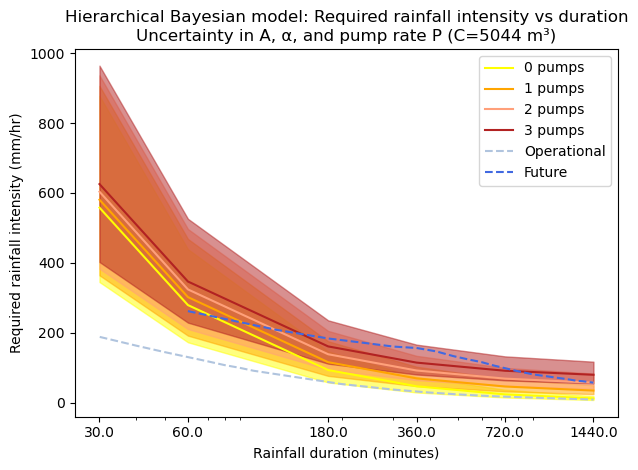

In [80]:
def plot_rainfall_to_disrupt(posterior_dict,ax=None,alpha=0.5,label="",color="blue"):
    """  
    Required rainfall to flood sump to at least 50% of the sump's capacity and cause disruption
    Args:
        posterior_dict (dict): keys are duration in seconds, values are samples of the posterior distribution
    """
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    t = np.array(list(posterior_dict))/60 # convert seconds to minutes
    median_vals = [np.percentile(v,50) for v in posterior_dict.values()]
    q_lower = [np.percentile(v,2.5) for v in posterior_dict.values()]
    q_upper = [np.percentile(v,97.5) for v in posterior_dict.values()]
    ax.semilogx(t,median_vals,label=label,c=color)
    ax.fill_between(t,q_lower,q_upper,alpha=alpha,color=color)

def calculate_probability_disruption(posterior_t, rf_obs):
    """  
    Probability of disruption given a rainfall intensity
    Args:
        posterior_t (array or list): posterior distribution of required rainfall intensity to flood sump over duration t
        rf_obs: given rainfall intensity, calculate probability of disruption
    """
    return (posterior_t <= rf_obs).mean()

# extreme scenario's precipitation
# t = [30, 60, 24*60]
# PUB_100RP = [189,130,8.4] #mm/h
# historical = [192,147,21.35]
# V3 = [282.4, 282.4, 63.22]
fig, ax = plt.subplots(1,1)
for n,c in zip(list(all_results),["yellow","orange","lightsalmon","firebrick"]):
    plot_rainfall_to_disrupt({t: all_results[n][t] for t in list(all_results[n])[1:]},
                               ax=ax,alpha=0.5,label=f"{n} pumps",color=c)
ax.plot(PUB_100RP_df["Time (mins)"] ,PUB_100RP_df["Rainfall Intensity (mm/hr)"],c="lightsteelblue",ls='--',label="Operational")
ax.plot(future_100RP_df["Time (mins)"],future_100RP_df["Rainfall Intensity (mm/hr)"],c="royalblue",ls='--',label="Future")
# ax.plot(t,historical,c="cornflowerblue",ls='--',label="Historical")
# ax.plot(t,V3,c="royalblue",ls='--',label="Future (V3)")
# Set custom x-axis tick locations and labels
x_tick_locations = x_tick_labels = np.array(list(all_results[n])[1:])/60
ax.set_xticks(x_tick_locations)
ax.set_xticklabels(x_tick_labels)
ax.set_xlabel("Rainfall duration (minutes)")
ax.set_ylabel("Required rainfall intensity (mm/hr)")
ax.set_title("Hierarchical Bayesian model: Required rainfall intensity vs duration\n"
        "Uncertainty in A, α, and pump rate P (C=5044 m³)")
plt.legend()
plt.tight_layout()
save_dir = r"data\simulatedExtremePluvialFlood\exported_figures"
save_fp = os.path.join(save_dir,"Rainfall_intensity_flood_mrt0.svg")
plt.savefig(save_fp, bbox_inches = 'tight')
plt.show()

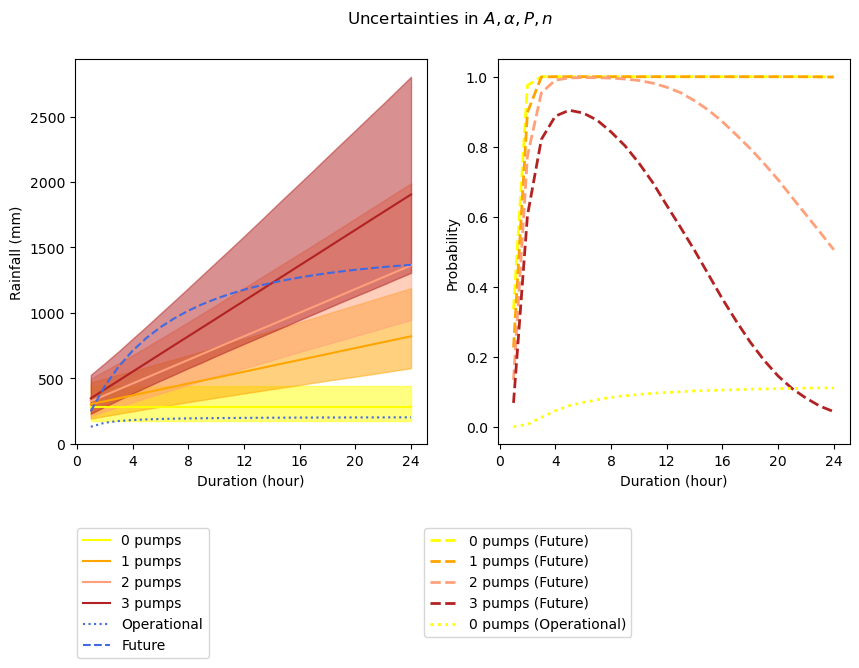

In [ ]:
def plot_rainfall_to_disrupt(posterior_dict,ax=None,alpha=0.5,label="",color="blue"):
    """  
    Required rainfall to flood sump to at least 50% of the sump's capacity and cause disruption
    Args:
        posterior_dict (dict): keys are duration in seconds, values are samples of the posterior distribution
    """
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    t = np.array(list(posterior_dict))/3600 # convert seconds to hours
    median_vals = [np.percentile(v,50) for v in posterior_dict.values()]
    q_lower = [np.percentile(v,2.5) for v in posterior_dict.values()]
    q_upper = [np.percentile(v,97.5) for v in posterior_dict.values()]
    ax.plot(t,median_vals,label=label,c=color)
    ax.fill_between(t,q_lower,q_upper,alpha=alpha,color=color)

def calculate_probability_disruption(posterior_t, rf_obs):
    """  
    Probability of disruption given a rainfall intensity
    Args:
        posterior_t (array or list): posterior distribution of required rainfall intensity to flood sump over duration t
        rf_obs: given rainfall intensity, calculate probability of disruption
    """
    return (posterior_t <= rf_obs).mean()

fig, axes = plt.subplots(1,2,figsize=(10,5))
# time duration
t = np.array(list(R_mm_results[0]))/3600 # convert seconds to hours
# interpolated IDF curve in mm
PUB_IDF_mm = interpolated_PUB*t
future_IDF_mm = interpolated_future*t
for n,c in zip(list(R_mm_results),["yellow","orange","lightsalmon","firebrick"]):
    plot_rainfall_to_disrupt(R_mm_results[n],ax=axes[0],alpha=0.5,label=f"{n} pumps",color=c)
    # plot probability of failure for future IDF
    axes[1].plot(t,[calculate_probability_disruption(dist,idf) for dist,idf in zip(R_mm_results[n].values(),future_IDF_mm)],
        color=c,label=f"{n} pumps (Future)",ls="--",lw=2)
# plot probability of failure for operational IDF (only if 0 pumps are functional)
axes[1].plot(t,[calculate_probability_disruption(dist,idf) for dist,idf in zip(R_mm_results[0].values(),PUB_IDF_mm)],
        color="yellow",label="0 pumps (Operational)",ls=":",lw=2)
axes[0].plot(t,PUB_IDF_mm,c="royalblue",ls=":",label="Operational")
axes[0].plot(t,future_IDF_mm,c="royalblue",ls="--",label="Future")
axes[0].set_ylabel("Rainfall (mm)")
axes[1].set_ylabel("Probability")
# axes[0].set_title("Distribution of required rainfall to exceed half of stormwater sump's capacity")
# axes[1].set_title("Probability of exceeding half of stormwater sump's capacity")
for ax in axes.flatten():
    ax.set_xlabel("Duration (hour)")
    ax.set_xticks(np.arange(0,25,4))
    ax.legend(bbox_to_anchor=(0.4,-0.2))

fig.suptitle(r"Uncertainties in $A, \alpha, P, n$")
save_dir = r"data\simulatedExtremePluvialFlood\exported_figures"
save_fp = os.path.join(save_dir,"fragility_curve_MRT_stormwater_sump0.svg")
plt.savefig(save_fp, bbox_inches = 'tight')
plt.show()

In [62]:
calculate_probability_disruption(all_results[0][1800], PUB_100RP[2])

np.float64(0.0)